In [1]:
# Check device number
!ls -ltrh /dev/video*

crw-rw---- 1 root video 81, 0 Apr 11 17:43 /dev/video0


In [12]:
from jetcam.usb_camera import USBCamera
from jetcam.csi_camera import CSICamera
import torchvision.transforms as transforms
from dataset import ImageClassificationDataset

import torch
import torchvision
import threading
import time
import torch.nn.functional as F
import torchvision.transforms as transforms
import cv2
import PIL.Image
import numpy as np

import ipywidgets
from IPython.display import display
from IPython.display import Image


In [3]:
# for USB Camera (Logitech C270 webcam), uncomment the following line
camera = USBCamera(width=224, height=224, capture_device=0) # confirm the capture_device number

camera.running = True
print("camera created")

# unobserve all callbacks from camera in case we are running this cell for second time
camera.unobserve_all()

device = torch.device('cuda')

classNum = 3 #left, front, right
# RESNET 18
#model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
#model.fc = torch.nn.Linear(512, classNum)
    
path='/nvdli-nano/data/classification/my_model_work_1.pth'
model = torch.load(path, map_location=torch.device('cuda'))
model.eval()

model = model.to(device)


mean = torch.Tensor([0.485, 0.456, 0.406]).cuda()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda()

def preprocess(image):
    device = torch.device('cuda')
    image = PIL.Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device)
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

idx = 0  

def live(model, camera):
    global dataset
    while True:
        image = camera.value
        preprocessed = preprocess(image)
        output = model(preprocessed)
        output = F.softmax(output, dim=1).detach().cpu().numpy().flatten()
        category_index = output.argmax()
        yield( category_index )


[ WARN:0@6.965] global cap_gstreamer.cpp:1728 open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


camera created


In [4]:
#next(live(model, camera))

In [26]:
def run():
    # 0 is back
    # 1 is stay
    # 2 is forward 
    pos1 = None
    pos2 = None

    i = 0

    dd = {0 : '/nvdli-nano/classification/take1.png', 1 : '/nvdli-nano/classification/take2.png'}
    display(Image(dd[1]))
    
    while True:
        pos1 = next(live(model, camera))
        pos2 = pos1
        pos1 = next(live(model, camera))
    
        #print(pos1, pos2)
    
        if pos1 == pos2: 
            continue 
        elif pos2 == 2:
            i+=1
            print('FORWARD')
        elif pos2 == 0:
            i-=1
            print('BACK')
        else:
            continue

        display(Image(dd[i%2]))

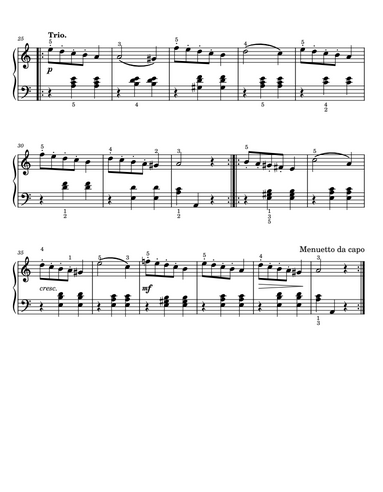

FORWARD


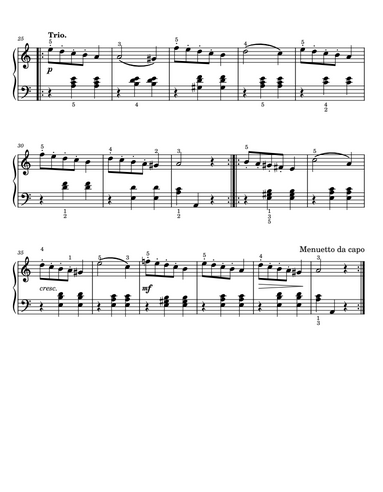

BACK


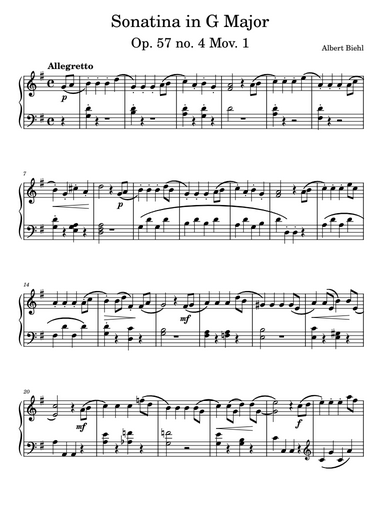

FORWARD


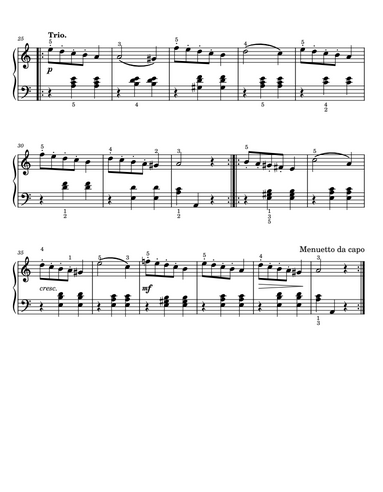

BACK


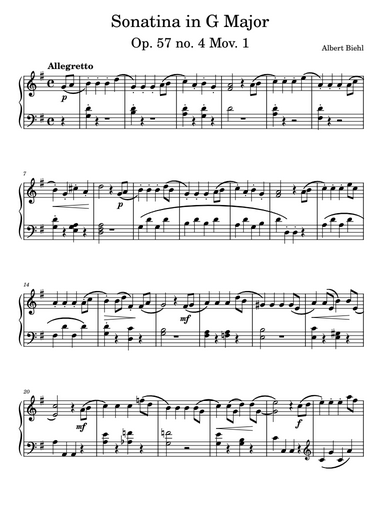

BACK


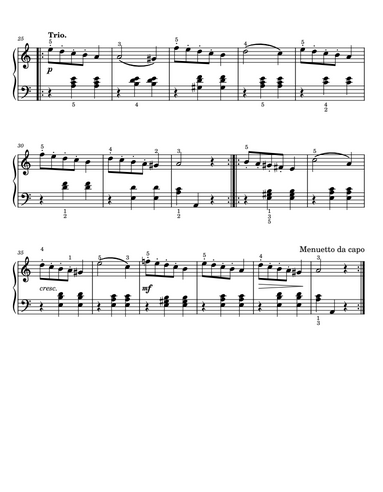

BACK


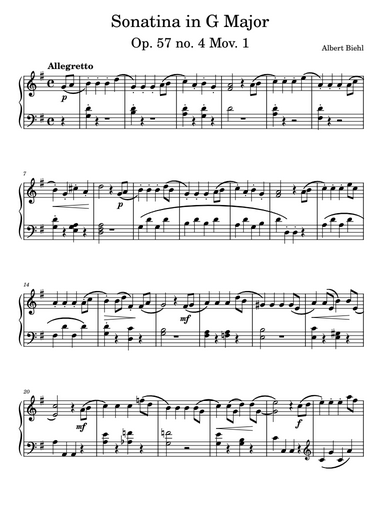

KeyboardInterrupt: 

In [27]:
run()

In [ ]:
#restart Kernel 
import os
import IPython

os._exit(00)